In [1]:
%matplotlib inline
import numpy as np
import sklearn as skl
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler, OneSidedSelection
from imblearn.over_sampling import SMOTE
sns.set_style('darkgrid')


資料預處理

In [2]:
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.feature_extraction import DictVectorizer
train_path = './TraData.csv'
data = pd.read_csv(train_path, sep=',') #.sample(100000) # toy
label_le = LE()
label = label_le.fit_transform(data.click)
del data['click'] # 記得別讓答案變成一組 feature ，這樣 model 就直接看到答案了
# 特徵選擇、降維 改交給 SVD 分解完成
del data['ip'] # ip 的 dimension 有 70多萬維，太高了我們不要它
del data['spaceCat']
del data['adType']
# del data['os']
del data['deviceType']
del data['publisherId']
del data['dclkVerticals']
# del data['campaignId']
# del data['advertiserId']
print list(data)
dv = DictVectorizer(sparse=False) # 要執行這步，你/妳的 RAM 要夠大 (>8G 一定沒問題)
data = dv.fit_transform(data.T.to_dict().values())
# print dv.vocabulary_
# print dv.feature_names_ 

print data[:3] ## 印出三筆資料觀察
print label[:3]

# pos_num = np.sum(label==1)
# neg_num = len(label)-pos_num
# pos_r = pos_num / float(len(label))
# neg_r = neg_num / float(len(label))
# print pos_r, neg_r # 印出類別權重
# class_weight = {0:pos_r, 1:neg_r} # 將類別出現次數乘上權重


['adx', 'spaceType', 'spaceId', 'os', 'campaignId', 'advertiserId']
[[  2.66000000e+02   0.00000000e+00   1.00000000e+00   4.61200000e+03
    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0

In [3]:
from sklearn.model_selection import train_test_split
data, X_test, label, Y_test = train_test_split(data, np.asarray(label).flatten(), test_size=0.1)
print data.shape
print X_test.shape
print label.shape
print Y_test.shape

(865311, 329)
(96146, 329)
(865311,)
(96146,)


設定模型參數、建構模型

In [4]:
import xgboost as xgb
param = {
    'objective': 'binary:logistic', # 二元分類的問題
    #'gamma': 0.2,                   # 用於控制是否後剪枝的引數,越大越保守，一般0.1、0.2這樣子。 0.2
    'max_depth': 5,                 # 構建樹的深度，越大越容易過擬合 5
    #'reg_lambda': 2.2,              # 控制模型複雜度的權重值的L2正則化項引數，引數越大，模型越不容易過擬合。
    'subsample': 0.9,               # 隨機取樣訓練樣本
    'colsample_bytree': 0.9,        # 生成樹時進行的列取樣
    'silent': 0,                    # 設定成 0 輸出 log 到 stderr
    'learning_rate': 0.01,          # 學習率
    #'seed': 1000,
    'scale_pos_weight': 16,         # 給正樣本的權重
    'nthread': 10,                   # cpu 執行緒數
    'n_estimators': 30             # 生幾棵樹
}

/home/applyACC/persons/peter0749/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
class_weight={0:1,1:16}
## DT on sklearn is based on CART algorithm. Let's try ID3&CART algorithm both. And SVM.
classifiers = {
                # 'SVC':SVC(kernel='rbf', class_weight=class_weight, max_iter=300), 
                #'LinearSVC':LinearSVC(class_weight=class_weight, max_iter=300),
                'XGBoost': xgb.XGBClassifier(**param),
                'DecisionTree': tree.DecisionTreeClassifier(max_depth=5, class_weight=class_weight),
                'RandomForest': RandomForestClassifier(max_depth=5, class_weight=class_weight),
                # 'KNN_dist': KNN(n_neighbors=3, weights='distance',),
                'KNN_uni': KNN(n_neighbors=3, weights='uniform',),
                # SVM 複雜度太高了，算不完 O(n^3~n^4), 使用簡單的 LinearSVM(O(N))]
                # 'Random':DummyClassifier('uniform'), ## 下面這兩個是 baseline ，不應該比亂猜/都猜0還差
                # 'Guess0':DummyClassifier('most_frequent')
              }

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# 要執行這步，你/妳的 RAM 要夠大 (>8G 一定沒問題)
svd = PCA(n_components=100) # 降維，維度太高會發生'維度災難'
svd_data = svd.fit_transform(data)
print svd_data.shape
print np.cumsum(svd.explained_variance_ratio_)
print 'info: %.2f'%np.sum(svd.explained_variance_ratio_)
print 'nans: %d'%np.sum(np.isnan(svd_data))

(865311, 100)
[ 0.89897272  0.99970436  0.99977868  0.99982865  0.99985943  0.99987674
  0.99988995  0.99990116  0.99991073  0.99991845  0.99992483  0.99993033
  0.99993471  0.99993817  0.9999411   0.99994362  0.99994593  0.99994818
  0.9999504   0.99995257  0.99995463  0.99995655  0.99995831  0.99995999
  0.99996154  0.99996292  0.99996415  0.99996528  0.99996631  0.99996729
  0.99996827  0.99996922  0.99997013  0.999971    0.99997186  0.99997271
  0.99997356  0.9999744   0.99997524  0.99997605  0.99997685  0.99997762
  0.99997838  0.99997913  0.99997984  0.99998052  0.99998119  0.99998184
  0.99998244  0.99998302  0.9999836   0.99998417  0.99998473  0.99998529
  0.99998583  0.99998638  0.99998689  0.99998737  0.99998784  0.99998827
  0.9999887   0.99998911  0.99998952  0.99998991  0.99999025  0.99999057
  0.99999088  0.99999118  0.99999147  0.99999176  0.99999203  0.9999923
  0.99999257  0.99999282  0.99999307  0.99999332  0.99999355  0.99999378
  0.999994    0.9999942   0.99999441  

In [7]:
data = svd_data
del svd_data

10-fold Cross-validation

In [8]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
models = []
cvscores = []
for model_name, model in classifiers.items():
    print('Training %s...'%model_name)
    tempscores = []
    for train, test in kfold.split(data, label):
        X, y = data[train], label[train]
        model.fit(X,y)
        pred = model.predict(data[test])
        pred[pred<0.5] = 0
        pred[pred>0] = 1
        score = f1_score(label[test], pred, average='binary')
        tempscores.append(score)
        models.append((str(model_name), model, score))
    print("f1.avg: %.4f%% (+/- %.4f%%)" % (np.mean(tempscores)*100., np.std(tempscores)*100.)) ## validation 的 f1-score 的平均值 +/- 兩倍標準差
    cvscores.extend(tempscores)

Training DecisionTree...
f1.avg: 16.4006% (+/- 4.3570%)
Training XGBoost...
f1.avg: 16.5955% (+/- 4.2549%)
Training RandomForest...
f1.avg: 17.1476% (+/- 4.6029%)
Training KNN_uni...


/home/applyACC/persons/peter0749/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


f1.avg: 2.1756% (+/- 2.3891%)


In [9]:
import pickle # export models
for i, (model_name, model, score) in enumerate(models):
    with open("%02d-%s-%.2f.pkl"%(i, str(model_name), score), "wb") as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [10]:
def load_model(model_path):
    model = None
    with open(str(model_path), 'rb') as handle:
        model = pickle.load(handle)
    return model

In [11]:
# pretrained_random_forest_model = load_model('path_to_model')
# pretrained_decision_tree_model = load_model('path_to_model')
# pretrained_xgb_model = load_model('path_to_model')
# pretrained_knn_model = load_model('path_to_model')

In [16]:
def voter(models, data):
    final_p = np.zeros(len(data))
    for i, entry in enumerate(models):
        model, score = entry[-2], entry[-1]
        pred = np.asarray(model.predict(data)).flatten()
        pred[pred<0.5]=-1 # 否決
        pred[pred>0]=1 # 肯定
        final_p += pred*score # 有權重的投票
    final_p[final_p<0] = 0
    final_p[final_p>0] = 1
    return final_p

In [17]:
# models = models[:30] # discard KNNs

In [18]:
from sklearn.model_selection import train_test_split
X_test_svd = svd.transform(X_test)
predicted = voter(models, X_test_svd)
confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
inclass_precision = skl.metrics.classification_report(Y_test, predicted)
score = f1_score(Y_test, predicted, average='binary')
print(confusion_metrix)
print(inclass_precision)
print(score)

[[95984    93]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.127167630058


SVD 分解、可視化

In [19]:
def plot_embedding(x_emb,y,n,title=''): ## visualization
    cmap = plt.cm.gist_ncar_r
    ax = plt.subplot()
    for l in xrange(n):
        points = x_emb[y==l,:]
        ax.scatter(points[:,0], points[:,1], label=l, c=cmap(float(l)/float(n)))
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [20]:
svdvis = PCA(n_components=2)
embedding = svdvis.fit_transform(X_test)

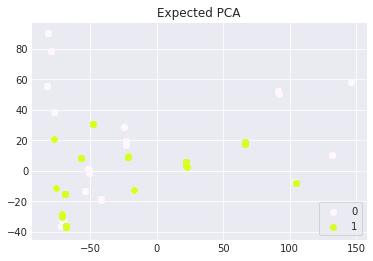

In [21]:
plot_embedding(embedding, Y_test, 2, 'Expected PCA') ## 視覺化, 看起來幾乎不是線性可分的

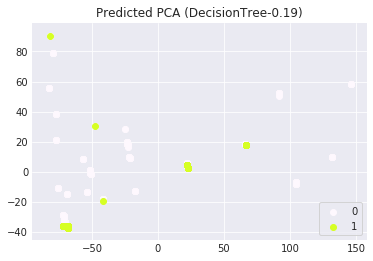

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


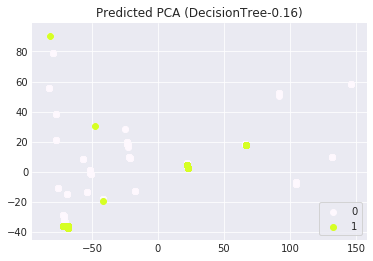

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


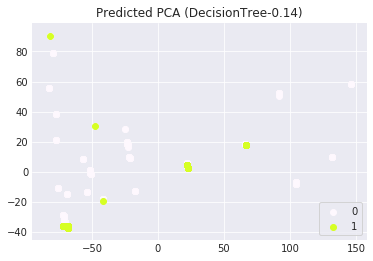

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


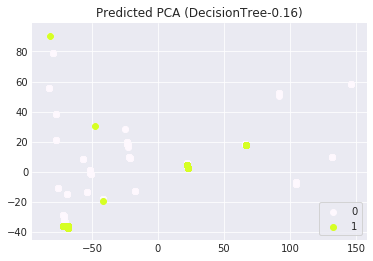

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


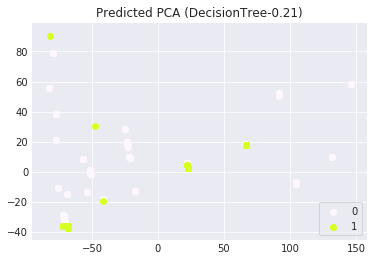

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


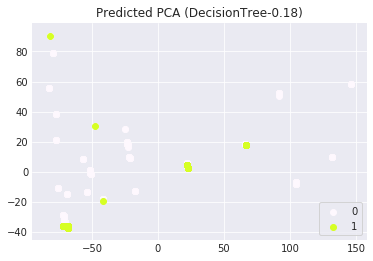

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


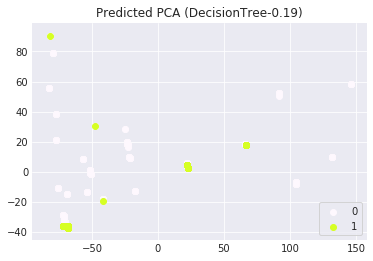

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


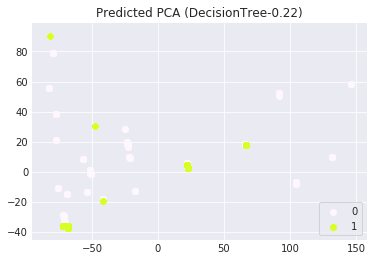

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


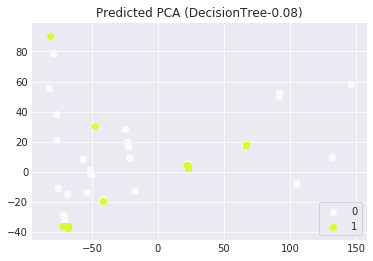

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


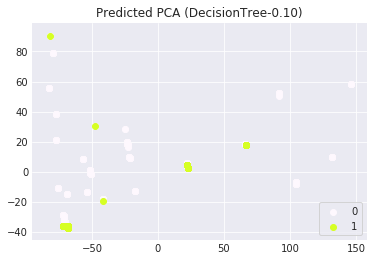

[[95982    95]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.10      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998408670147


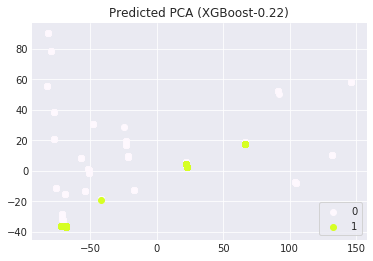

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


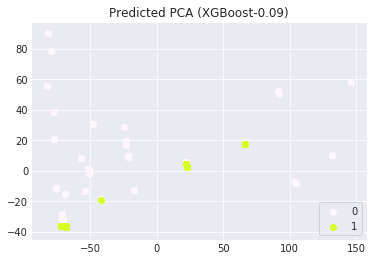

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


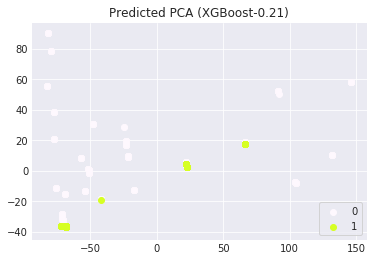

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


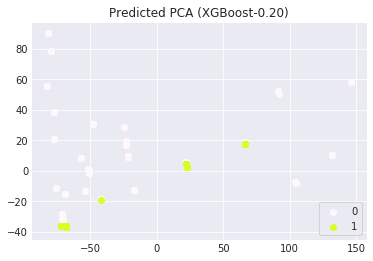

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


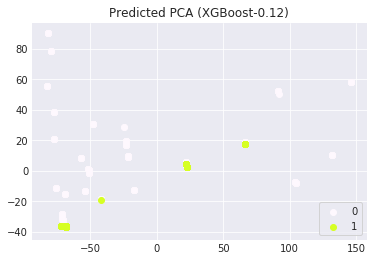

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


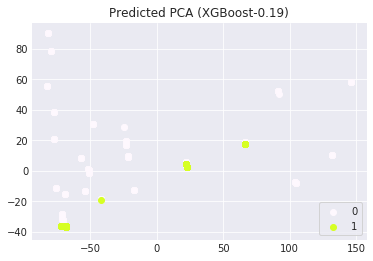

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


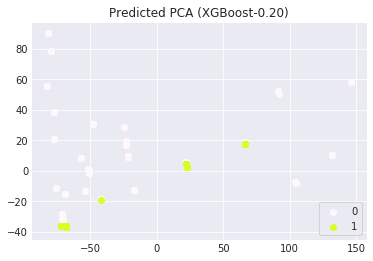

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


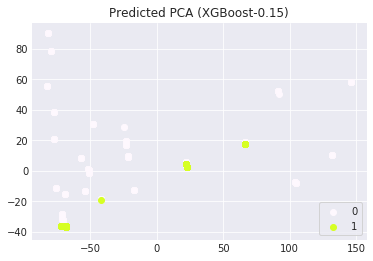

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


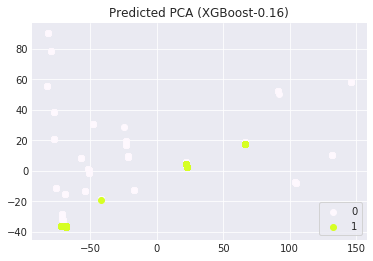

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


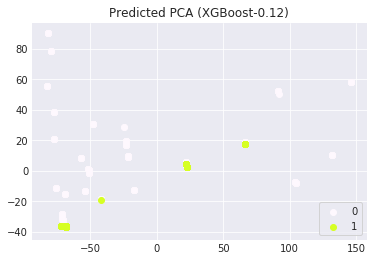

[[95975   102]
 [   57    12]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.17      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998346265055


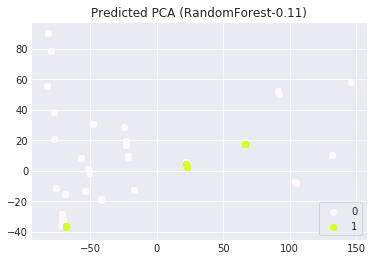

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


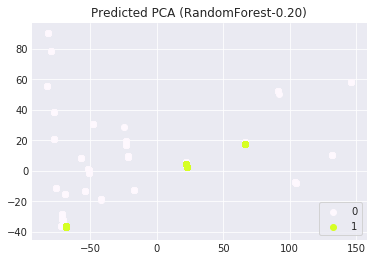

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


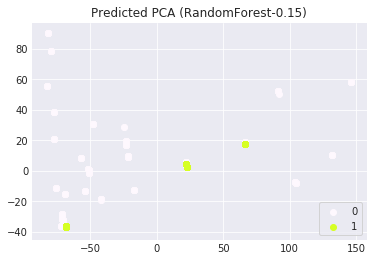

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


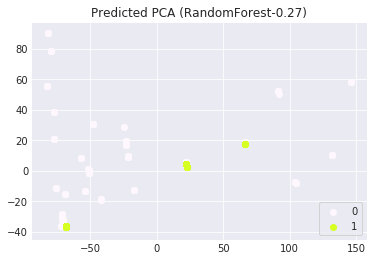

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


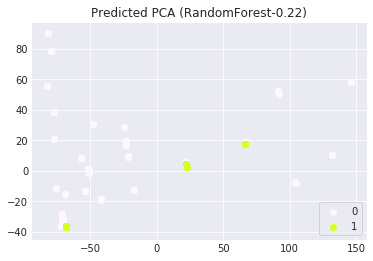

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


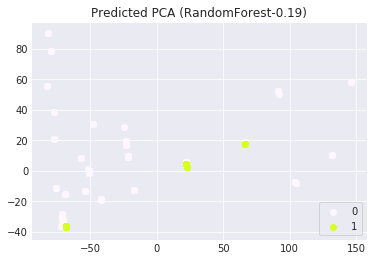

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


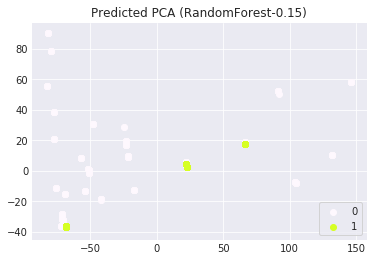

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


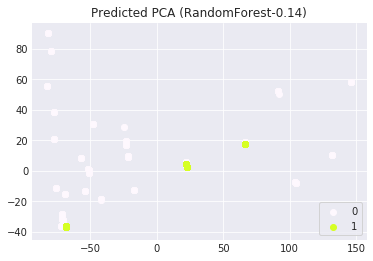

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


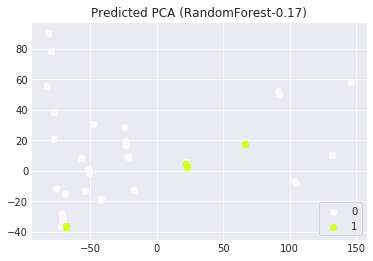

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


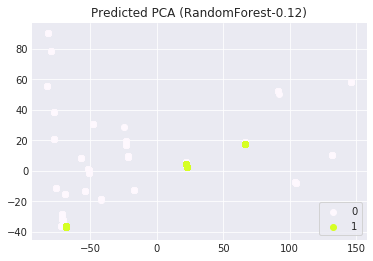

[[95992    85]
 [   58    11]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96077
          1       0.11      0.16      0.13        69

avg / total       1.00      1.00      1.00     96146

0.998512678635


In [22]:
for (model_name, model, score) in models: ## 但也不能高興得太早，recall 看起來應該不會太好
    predicted = model.predict(X_test_svd)
    confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
    plot_embedding(embedding, predicted, 2, 'Predicted PCA (%s-%.2f)'%(model_name, score))
    inclass_precision = skl.metrics.classification_report(Y_test, predicted)
    score = f1_score(Y_test, predicted, average='micro')
    print(confusion_metrix)   ## 看看每個 model 在未知的資料上表現如何，判斷模型是否 underlearning, 注意，我們只在乎 label==1 的部分
    print(inclass_precision)  ## 同上
    print(score)

補充從 R script 得到的這份 training data 的 ANOVA 結果（從九十萬筆資料隨機抽樣5000筆資料）：

```R
               Df Sum Sq  Mean Sq   F value Pr(>F)    
adx             1  0.000 0.000003 2.192e+23 <2e-16 ***
spaceType       1  0.000 0.000011 9.356e+23 <2e-16 ***
spaceId       128  0.516 0.004034 3.451e+26 <2e-16 ***
ip           4839  3.480 0.000719 6.154e+25 <2e-16 ***
os              3  0.000 0.000000 2.000e-03 0.9999    
campaignId      1  0.000 0.000000 3.089e+00 0.0911 .  
advertiserId    1  0.000 0.000000 1.496e+00 0.2327    
Residuals      25  0.000 0.000000                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

可以看出 adx, spaceType, spaceId, ip 對 click 的影響似乎是顯著的？

也許可以實驗看看只選擇 adx, spaceType, spaceId, ip 當作 feature？或是使用 PCA 做降維？

因為他們對 click 的影響較顯著？ p<0.05